# <a id='toc1_'></a>[深層学習ノートブック-15 Learning Rate Finder & Scheduler](#toc0_)
学習率は深層学習において最も重要なハイパーパラメータの一つである。  
__Learning Rate Finder__ という下記のような手法を使えば、学習率の初期値の目安を探すことが出来る。  
1. 非常に小さい値(例:1e-8)を学習率に設定する
2. 各"ミニバッチ"の学習毎に徐々に(log scaleで)学習率を大きくする
3. ある程度大きくなると、損失が急激に上昇し始める(適切な学習率の上限)
4. 損失と学習率のグラフを描き、損失が下がり始める範囲の学習率を使用する(ここが良い学習率の範囲とされる)  

対して __Learning Rate Scheduler__ は深層学習のモデル学習中に学習率を動的に調整することで、  
パラメタが局所解に陥る問題を緩和する仕組みである。  
例えば、学習初期（epoch回数小）は学習率を高めにして広範囲に最適解を探索し、  
最適解の近くに来たら徐々に学習率を小さくして精度を高くするなど。  

**Table of contents**<a id='toc0_'></a>    
- [深層学習ノートブック-15 Learning Rate Finder & Scheduler](#toc1_)    
  - [■ Learning rate finderをスクラッチで実装する](#toc1_1_)    
  - [■ Learning rate finderをスクラッチで実装する](#toc1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

参考：  
* [Udemy講座：「①米国AI開発者がやさしく教える深層学習超入門第一弾【Pythonで実践】」](https://www.udemy.com/course/deeplearning1/learn/lecture/40143418)

## <a id='toc1_1_'></a>[■ Learning rate finderをスクラッチで実装する](#toc0_)
PytorchにはLearning rate finderは実装されていない※ので、自分で実装する必要あり。また、この方が応用も効く。

※サードパーティーライブラリのPytorch Lightningnにはある模様

In [21]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [22]:
class MLP_1(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        # 親クラスのinitを呼び出す。
        super().__init__()
        # nn.Flattenにより[b, c, h, w] -> [b, c x h x w]（ミニバッチサイズ, 画像の特徴量数の積）に変換
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(num_in, num_hidden)
        self.linear_2 = nn.Linear(num_hidden, num_out)

    # nn.Moduleにもforwardメソッドがあり、ここでオーバーライドしている。
    def forward(self, x):
        # 最初の全結合層の計算に渡す際にnn.Flattenを実行しておく必要あり。
        z = self.linear_2( F.relu( self.linear_1(self.flatten(x))) )
        return z
    

class MyDataset(Dataset):
    def __init__(self, X, y, transform=None) -> None:
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self): #lenを適用したときの挙動を定義
        return len(self.X)
    
    def __getitem__(self, idx): #indexingしたときの挙動
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)
        
        return X, y

In [6]:
# 学習率の目安を探すための関数
def learning_rate_finder(model, train_loader, loss_func, lr_increase_ratio=1.1):

    # 学習率の初期値は小さく定義。最大値を超えたら探索をやめる
    lr = 1e-8
    max_lr = 10
    # 学習率と損失記録用リスト
    lr_history = []
    loss_history = []

    # Optimizer定義。学習率は後で変更できる。
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for idx_batches, data in enumerate(train_loader):
        X_train, y_train = data

        # 順伝播
        y_pred = model(X_train)
        loss = loss_func(y_pred, y_train)

        # 逆伝搬
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # グラフ描画用情報記録。学習率は見やすさのためにlog scaleにしておく。
        loss_history.append(loss.item())
        lr_history.append(lr)
        print(f"ミニバッチidx: {idx_batches}, 学習率: {lr}, 損失: {loss.item()}")
        # print(f'Optimizer: {optimizer.param_groups[0]["lr"]}')

        # optimizerの学習率更新。lrの更新は表示用
        lr *= lr_increase_ratio
        optimizer.param_groups[0]["lr"] = lr

        if lr > max_lr:
            break

    return lr_history, loss_history   


In [7]:
# バッチサイズを定義。今回は１ミニバッチ＝３２データとする
batch_size = 8

# データ読み込み。8x8のMNISTデータセットをカスタムデータセットとして読み込む。（練習のため）
dataset = datasets.load_digits()
X = dataset['images'] # 0~16の値をもつ
X = ( X * (255. / 16.) ).astype(np.uint8)
y = dataset['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
transform = transforms.Compose([
    transforms.ToTensor(), # 0~255 -> 0~1
    transforms.Normalize((0.5,), (0.5)) # 0~1 -> -1~1
])

# Datasetとして読み込み
train_dataset = MyDataset(X_train, y_train, transform=transform)
val_dataset = MyDataset(X_val, y_val, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

# モデルのコンストラクタに渡す引数を定義。
num_in = 64
num_hidden = 30
num_out = 10

# モデル定義（２層のMLP）
MLP_model = MLP_1(num_in=num_in, num_hidden=num_hidden, num_out=num_out)

# requires_grad_をTrueに設定。最後に_がつくのは設定するという意味。
MLP_model.requires_grad_(True)

# torch.optimを使ってOptimizerを定義
# optimizer = optim.SGD(MLP_model.parameters(), lr=0.03)

MLP_1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=64, out_features=30, bias=True)
  (linear_2): Linear(in_features=30, out_features=10, bias=True)
)

In [191]:
lr_log, loss_log = learning_rate_finder(MLP_model, train_loader, F.cross_entropy, 1.11)

ミニバッチidx: 0, 学習率: 1e-08, 損失: 2.218879222869873
ミニバッチidx: 1, 学習率: 1.1100000000000002e-08, 損失: 2.3103322982788086
ミニバッチidx: 2, 学習率: 1.2321000000000003e-08, 損失: 2.3134565353393555
ミニバッチidx: 3, 学習率: 1.3676310000000004e-08, 損失: 2.233304977416992
ミニバッチidx: 4, 学習率: 1.5180704100000005e-08, 損失: 2.263347625732422
ミニバッチidx: 5, 学習率: 1.6850581551000006e-08, 損失: 2.3670766353607178
ミニバッチidx: 6, 学習率: 1.870414552161001e-08, 損失: 2.207068920135498
ミニバッチidx: 7, 学習率: 2.0761601528987113e-08, 損失: 2.2834975719451904
ミニバッチidx: 8, 学習率: 2.3045377697175696e-08, 損失: 2.3531103134155273
ミニバッチidx: 9, 学習率: 2.5580369243865024e-08, 損失: 2.2005245685577393
ミニバッチidx: 10, 学習率: 2.839420986069018e-08, 損失: 2.2378485202789307
ミニバッチidx: 11, 学習率: 3.15175729453661e-08, 損失: 2.192047119140625
ミニバッチidx: 12, 学習率: 3.498450596935637e-08, 損失: 2.1455392837524414
ミニバッチidx: 13, 学習率: 3.883280162598558e-08, 損失: 2.3866426944732666
ミニバッチidx: 14, 学習率: 4.3104409804844e-08, 損失: 2.231158494949341
ミニバッチidx: 15, 学習率: 4.7845894883376844e-08, 損失: 2.323

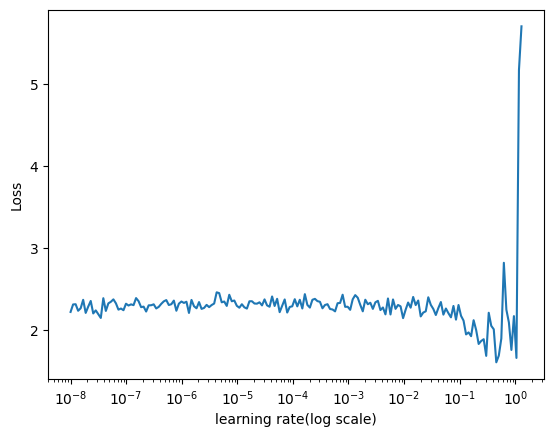

In [193]:
sns.lineplot(x=lr_log, y=loss_log)
plt.xlabel('learning rate(log scale)')
plt.ylabel('Loss')

# 学習率はlog scaleで描画
plt.xscale('log')


上記のように学習率が大きくなり過ぎると損失が発散するので、  
損失が下がり始める10^-1近傍(実スケールで0.25ぐらい)の学習率を採用するとよいということが分かる。  

(1e-07, 2.0)

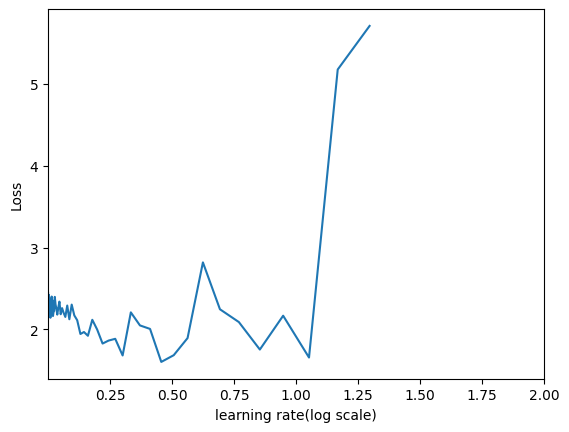

In [208]:
sns.lineplot(x=lr_log, y=loss_log)
plt.xlabel('learning rate(log scale)')
plt.ylabel('Loss')

# 学習率はlog scaleで描画
# plt.xscale('log')
plt.xlim((1e-7, 2))


## <a id='toc1_2_'></a>[■ Learning Rate Scheduler(LR Scheduler)](#toc0_)
pytorchには下記のようなLR Schedulerが実装されている。  
torch.optim.lr_schedulerモジュールにて様々なschedulerクラスが提供されている。→[pytorchドキュメント](https://pytorch.org/docs/stable/optim.html#)  
* Step LR: 指定したstep(epoch)数毎に学習率を減少
* MulbStepLR: 指定した複数のepochで学習率を減少
    * 100epoch目からlr=0.05、1000epoch目からlr=0.01に設定するなど
* ExponenbalLR: epoch毎に指数関数的に減少
* CosineAnnealingLR: cosine曲線に従って徐々に減少
* CyclicLR: 周期的に学習率を変動させることで、局所解にトラップされることを防ぐ
* CosineAnnealingWarmRestarts: 学習中に学習率を初期化するwarm restartsを伴いながらCosine Annealingで学習率を変動
    * 学習の途中で学習率が初期化される（大きくなる）ことで様々な解に落ちやすくなるので、  
    その分だけ局所解ではなく最適解に落ちる(=最も低い損失となるパラメタが見つかる)可能性が高まる。  

ここではStep LRとCosineAnnealing LRを実践してみる。    

1. インスタンスを生成
    * 第一引数にoptimizerオブジェクトを渡す
    * その他のパラメータを引数に渡す
2. .step()メソッドで，optimizerのlearning rateを更新する
    * Step LR
        * optimizer: optimizerオブジェクト
        * step_size: 学習率を減少させるstep数
            * .step()が呼ばれた回数を内部でカウントしており、そのカウントがstep_sizeに達したら学習率が減少する実装になっている。  
            　そのため、通常のepochのループの中で単に.step()を毎回呼び出せばOK。
        * gamma: 学習率の減衰率. step_sizeのepoch毎に学習率にgammaを乗ずる
    * CosineAnnealingLR
        * optimizer: optimizerオブジェクト
        * T_max: 最大値から最小値になるまでのイテレーション数

### - Step LR

In [12]:
# Step LR
MLP_model = MLP_1(64, 30, 10)
optimizer = optim.SGD(MLP_model.parameters(), lr=0.01)

# step LRのscedulerインスタンスを生成
step_lr_scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

print(f"step前の学習率：{optimizer.param_groups[0]['lr']}")

# stepさせる。30回stepを呼び出すことで学習率にgammaが乗算される。
for _ in range(30):
    # PyTorch 1.1.0以降ではschedularのstepの前にoptimizerのstepをcallしておかないと警告が出る。
    optimizer.step()
    step_lr_scheduler.step()


print(f"step後の学習率：{optimizer.param_groups[0]['lr']}")

step前の学習率：0.01
step後の学習率：0.001


確かにstep前の学習率に対してgammaが乗算されている。

### - CosineAnnealingLR

In [19]:
# Step LR
MLP_model = MLP_1(64, 30, 10)
optimizer = optim.SGD(MLP_model.parameters(), lr=0.01)

# cosine Annealing LRのscedulerインスタンスを生成。学習率の半周期は50epochとする。
cosine_ann_lr_scheduler = CosineAnnealingLR(optimizer, T_max=50)
lr_history = []

print(f"step前の学習率：{optimizer.param_groups[0]['lr']}")

# stepさせる。150回stepを呼び出し、周期を確認する。
for _ in range(150):
    # 学習率を記録
    lr_history.append(optimizer.param_groups[0]['lr'])

    # PyTorch 1.1.0以降ではschedularのstepの前にoptimizerのstepをcallしておかないと警告が出る。
    optimizer.step()
    cosine_ann_lr_scheduler.step()


step前の学習率：0.01


Text(0, 0.5, 'lr')

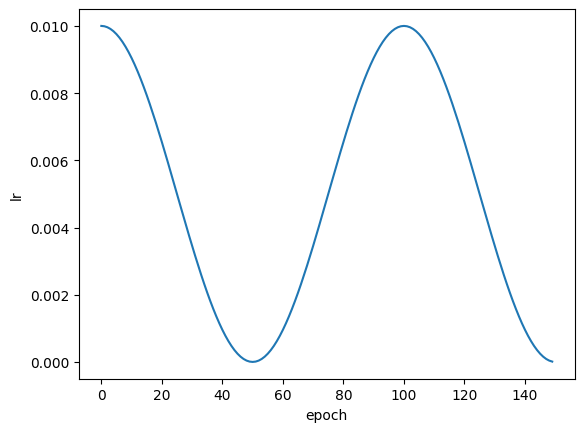

In [20]:
plt.plot(lr_history)
plt.xlabel('epoch')
plt.ylabel('lr')

100epochごとに学習率が1周期変化していることが分かる。

### ■ Learning Rate Schedulerを学習ループに組み込む

In [57]:
# バッチサイズを定義。今回は１ミニバッチ＝３２データとする
batch_size = 32

# データ読み込み。8x8のMNISTデータセットをカスタムデータセットとして読み込む。（練習のため）
dataset = datasets.load_digits()
X = dataset['images'] # 0~16の値をもつ
X = ( X * (255. / 16.) ).astype(np.uint8)
y = dataset['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
transform = transforms.Compose([
    transforms.ToTensor(), # 0~255 -> 0~1
    transforms.Normalize((0.5,), (0.5)) # 0~1 -> -1~1
])

# Datasetとして読み込み
train_dataset = MyDataset(X_train, y_train, transform=transform)
val_dataset = MyDataset(X_val, y_val, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

# モデルのコンストラクタに渡す引数を定義。
num_in = 64
num_hidden = 30
num_out = 10

# モデル定義（２層のMLP）
MLP_model = MLP_1(num_in=num_in, num_hidden=num_hidden, num_out=num_out)

# requires_grad_をTrueに設定。最後に_がつくのは設定するという意味。
MLP_model.requires_grad_(True)

# torch.optimを使ってOptimizerを定義
optimizer = optim.SGD(MLP_model.parameters(), lr=0.03)

# schedulerにはcosine annealing lrを指定
cosine_ann_lr_scheduler = CosineAnnealingLR(optimizer, T_max=50)

In [58]:
# MLPの学習ループを関数化
def learn(MLP_model, train_loader, val_loader, optim, loss_func, epoch=10, early_stopping=None, save_path=None, lr_scheduler=None):
    '''
    MLP_model: 任意のMLPモデル
    train_loader: 学習データのDataLoader
    val_loader: 検証データのDataLoader
    optim: optimizer
    loss_func: 損失関数
    epoch: epoch数。デフォルトは10。
    early_stopping: early_stopping判定の際のepoch数。デフォルトはearly_stoppingしない。
    save_path: モデルのパラメタやoptimizerのパラメタを保存する先を指定。デフォルトは保存しない。
    lr_scheduler: Learning Rate Schedulerを指定
    '''

    # 学習・検証結果格納用辞書
    train_results = {}
    best_params_and_Loss = {}

    # early_stoppingの判定用のカウンターとそのepoch時点での最小の損失を記録する用変数。初期値は無限大を指定。
    early_stopping_counter = 0 
    min_Loss_val = float('inf') # infinity

    for i, _ in enumerate(range(epoch)):

        # 各バッチでの学習データと検証データに対するloss、accuracyを累積する用の変数
        cum_loss = 0
        cum_loss_val = 0
        cum_accuracy_val = 0

        for num_batches, train_data in enumerate(train_loader):
            # 学習データ定義
            X_train_batch, y_train_batch = train_data

            # 順伝播の計算
            y_pred = MLP_model(X_train_batch)
            loss = loss_func(y_pred , y_train_batch)
            cum_loss += loss.item()
            
            # 逆伝播の計算、パラメタ更新
            loss.backward()
            optim.step()
            optim.zero_grad()


        # 検証データに対する損失を計算。こちらもバッチ単位で評価するように変更。（検証データ数が多いときはこの方が効率的）
        with torch.no_grad():
            for num_batches_val, val_data in enumerate(val_loader):
                X_val, y_val = val_data
                y_pred_val = MLP_model(X_val)
                loss_val = loss_func(y_pred_val, y_val)
                accuracy_val = ( (torch.argmax(y_pred_val, dim=1) == y_val).sum() / len(y_val) )
                # バッチごとの損失、accuracyを累積
                cum_loss_val += loss_val.item()
                cum_accuracy_val += accuracy_val.item()


        # 損失、accuracyを記録。
        # DataLoaderからのイテレーションの数＋１が実際のミニバッチ数になるので、累積した損失等をこれで割ってepochごとに計算
        train_results[f"epoch_{i}"] = {
            "Loss_train": cum_loss / (num_batches + 1),
            "Loss_val": cum_loss_val / (num_batches_val + 1),
            "Accuracy": cum_accuracy_val / (num_batches_val + 1),
        }

        print(f'epoch_{i}: {train_results[f"epoch_{i}"]}, Learning Rate: {optim.param_groups[0]["lr"]}')


        if early_stopping:
            # i番目のepochの損失がその時点の最小の損失よりも大きい場合、early_stoppingのカウンターを1増やす。
            # そうでない場合、最小の損失値を更新し、カウンターを0に戻す。(暫定チャンピオン方式)
            if train_results[f"epoch_{i}"]["Loss_val"] >= min_Loss_val:
                early_stopping_counter += 1
            else:
                min_Loss_val = train_results[f"epoch_{i}"]["Loss_val"]
                epoch_min_Loss_val = i
                early_stopping_counter = 0

                # save_pathがNoneではなければ保存する
                # 改善されていれば以下の辞書を更新する
                if save_path:
                    best_params_and_Loss = {
                        "epoch": epoch_min_Loss_val,
                        "Model_param": MLP_model.state_dict(),
                        "Optimizer_param": optim.state_dict(),
                        "Loss_val": min_Loss_val
                    }
            
            if early_stopping_counter >= early_stopping:
                print("early stoppingにより学習を終了します。")
                print(f"検証データに対する損失が最小となるepoch: {epoch_min_Loss_val}")
                break
        
        # 学習率の更新
        if lr_scheduler:
            lr_scheduler.step()


    # 　パラメタ保存ありの場合、ファイルに保存
    if early_stopping and save_path: torch.save(best_params_and_Loss, save_path)

    return train_results, best_params_and_Loss

In [59]:
# 学習ループ実行
train_result, params_result = learn(MLP_model, train_loader, val_loader, optimizer, F.cross_entropy,
                          epoch=300, early_stopping=None, save_path=None, lr_scheduler=cosine_ann_lr_scheduler)

epoch_0: {'Loss_train': 2.176036591000027, 'Loss_val': 2.04877907037735, 'Accuracy': 0.4765625}, Learning Rate: 0.03
epoch_1: {'Loss_train': 1.8714814000659519, 'Loss_val': 1.7122742831707, 'Accuracy': 0.7265625}, Learning Rate: 0.02997040092642407
epoch_2: {'Loss_train': 1.5005296972062854, 'Loss_val': 1.335620750983556, 'Accuracy': 0.84375}, Learning Rate: 0.029881720519717166
epoch_3: {'Loss_train': 1.1389678650432162, 'Loss_val': 0.9942757288614908, 'Accuracy': 0.8932291666666666}, Learning Rate: 0.029734308760930327
epoch_4: {'Loss_train': 0.8563568578826056, 'Loss_val': 0.763177901506424, 'Accuracy': 0.90625}, Learning Rate: 0.02952874741692946
epoch_5: {'Loss_train': 0.6623831563525729, 'Loss_val': 0.6045586268107096, 'Accuracy': 0.8880208333333334}, Learning Rate: 0.0292658477444273
epoch_6: {'Loss_train': 0.5320410774813757, 'Loss_val': 0.5052259291211764, 'Accuracy': 0.8984375}, Learning Rate: 0.028946647288323767
epoch_7: {'Loss_train': 0.4458507789505853, 'Loss_val': 0.4334

### 学習の推移を確認

In [60]:
train_losses = []
val_losses = []

for value in train_result.values():
    train_losses.append(value['Loss_train'])
    val_losses.append(value['Loss_val'])

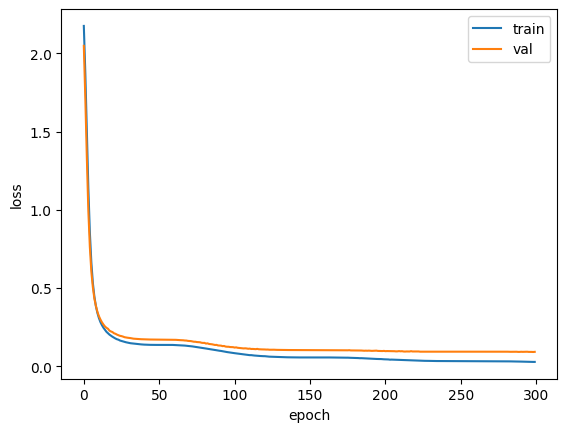

In [61]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

cosine lrの周期(epoch=100)ごとに段階的に損失が落ちているのが分かる。  
0→50は学習率が小さくなっていき、局所解に落ちそうになったところを50→100で学習率が上昇したことで、  
これを回避することに成功しているように見える。